## Notebook showing how to use the constellation code to generate constellation images offline. To have a quick look at the working, please use the (Colab Demo.ipynb) version by uploading to colab. 

For this version download the the trained Mask RCNN model as explained in readme and extract it in the directory of this notebook.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import cv2
import tensorflow as tf
import coco_metric

In [2]:
from constellations_tools import *

## Utility code from Mask RCNN demo

You can replace your own Mask RCNN implementation and use the rest of the pipeline, same way.

In [3]:
# mapping used from original Mask RCNN tuitorial : https://colab.research.google.com/github/tensorflow/tpu/blob/master/models/official/mask_rcnn/mask_rcnn_demo.ipynb
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

### Tensorflow Inits

In [4]:
g = tf.Graph()
session = tf.Session(graph=g)

2022-04-01 16:30:08.590782: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 16:30:08.616166: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2194530000 Hz
2022-04-01 16:30:08.616659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55863f1f4b30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-01 16:30:08.616719: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 16,36
OMP: Info #156: KMP_AFFINITY: 2 ava

In [5]:
mdl = tf.saved_model.loader.load(session, ['serve'], 'segmentation_model8')

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from segmentation_model8/variables/variables


## Actual Demo: 
### Load an image
Now, you can load an image. Use either the sample image included here, or update the field with an image of your choice.

In [6]:
with open('apple_10s_small.jpg', 'rb') as f:
    np_image_string = np.array([f.read()])
image = Image.open('apple_10s_small.jpg')
width, height = image.size

In [7]:
segmentations = detect(np_image_string,width,height,session) # Get  all Mask-RCNN segmentation masks

OMP: Info #250: KMP_AFFINITY: pid 41959 tid 42200 thread 1 bound to OS proc set 36
OMP: Info #250: KMP_AFFINITY: pid 41959 tid 42218 thread 2 bound to OS proc set 16
OMP: Info #250: KMP_AFFINITY: pid 41959 tid 42199 thread 3 bound to OS proc set 36
OMP: Info #250: KMP_AFFINITY: pid 41959 tid 42220 thread 4 bound to OS proc set 16


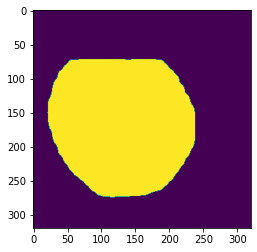

In [8]:
plt.imshow(segmentations[2])

### Manual Choices

A lot of manual fine tuning and choices need to be made at this step to get the best outline

In [9]:
# Choices for the best outline shall be made here, some cleaning is done manually if needed
image = np.array(image)
seg = segmentations[0]   # one may have to chose 1,2 or 3 shapes here
seg[np.where(seg>0) ]=1
for l in range(3):
    image[:,:,l]= image[:,:,l]*seg
edges_out = cv2.Canny(seg,1,1) # segment outer edge, some images may look better not including this
image = cv2.blur(image, (3,3))
edges = cv2.Canny(image,80,200) # the parameters of this is one choice that user may have to make
edges = edges | edges_out # again some images may look better without the outser edge

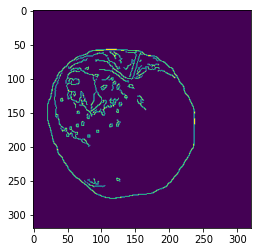

In [10]:
plt.imshow(edges)

## Generate dotted image

In [11]:
dotted = generate_image_dotted(edges,30,2) # the two parameters here should be controlled i.e distance between dots 'd' , radius of dots


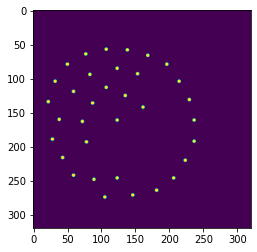

In [12]:
plt.imshow(dotted)

## add noise

In [13]:
final = add_noise(dotted,prob = 0.001,dot =2 ) # two paramters here, probability of noise ('p') , diameter of dots (will remian same as above)

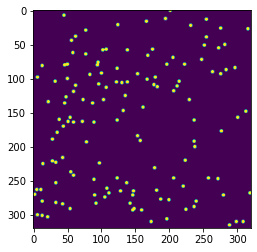

In [14]:
plt.imshow(final)